# 고객 데이터 분석을 통한 고객 세그먼트 도출
수퍼마켓 몰 고객 데이터 분석을 통해 고객 세그먼트를 도출하고 그 사용법을 고민해봅니다. 

## 데이터 설명
데이터는 [다음의 링크](https://drive.google.com/file/d/1H2e6Yl4ME7CL_D3Bs00DmfN5WGnEJJhA/view?usp=sharing)에서 다운받으실 수 있습니다(https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).


---





  * **CustomerID** - 고객들에게 배정된 유니크한 고객 번호 입니다. 
  * **Gender** - 고객의 성별 입니다. 
  * **Age** - 고객의 나이 입니다. 
  * **Annual Income (k$)** - 고객의 연소득 입니다. 
  * **Spending Score (1-100)** - 고객의 구매행위와 구매 특성을 바탕으로 mall에서 할당한 고객의 지불 점수 입니다. 

---







## 문제 정의 
*  전제
  * 주어진 데이터가 적절 정확하게 수집, 계산된 것인지에 대한 검증부터 시작해야하지만, 지금은 주어진 데이터가 정확하다고 가정합니다. (예: Spending Score는 적절하게 산출된 것이라 확신하고 시작합니다)
  * 주어진 변수들을 가지고 고객 세그먼트를 도출합니다.  
  * 가장 적절한 수의 고객 세그먼트를 도출합니다.   
* 분석의 목적 
  * 각 세그먼트 별 특성을 도출합니다.  
  * 각 세그먼트별 특성에 맞는 활용방안, 전략을 고민해봅니다. 

### 데이터 탐색

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# 데이터를 불러옵니다.
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [0]:
# 데이터를 확인 합니다. 
df = pd.read_csv("Mall_Customers.csv")
print(df.shape)
df.tail()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [0]:
# 결측값이 있는지 확인합니다. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [0]:
# 기술통계를 확인합니다. 
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


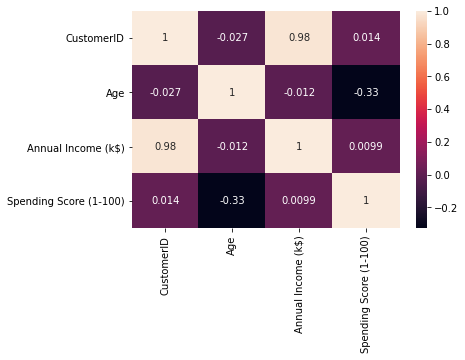

In [0]:
# 변수간의 correlation을 확인합니다. 
corr = df.corr()
sns.heatmap(corr, annot=True)

In [0]:
# 컬럼명을 출력합니다. 
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'cluster'],
      dtype='object')

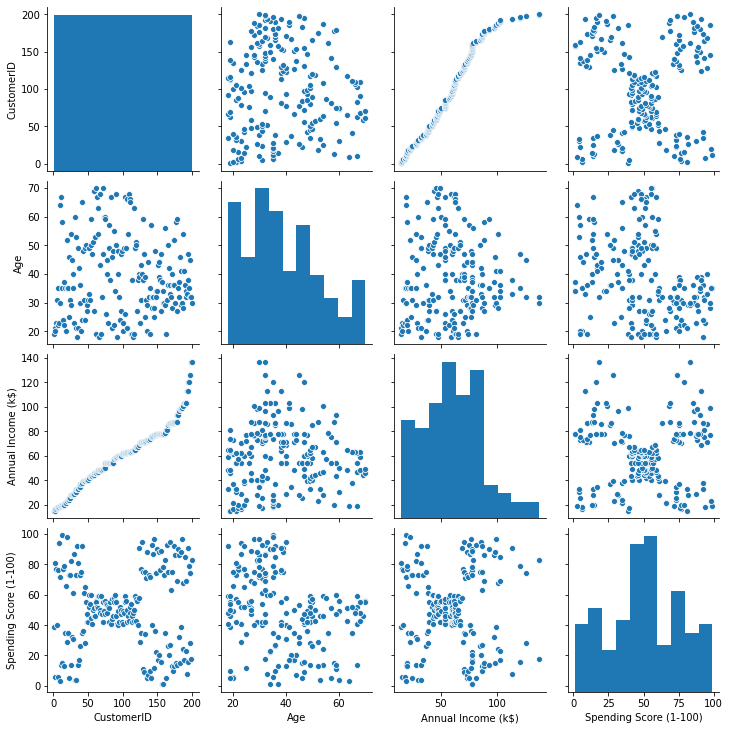

In [0]:
# 변수간의 pairplot을 그려봅니다. 
sns.pairplot(df[['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)']])
plt.show()

* 샘플데이터여서인지, scatter plot을 보는 것만으로도 세그먼트가 눈에 보이는 것 같습니다.
* 특히 Spending Score와 Annual Income사이의 관계에 따라 5개의 세그먼트가 나눠지는 것 처럼 보입니다. 
* 각 세그먼트는 해석이 가능합니다. 
* 실제 데이터는 이렇게 예쁘게 나눠떨어지기 어렵다는 점을 감안하고 분석을 계속 해봅니다.  

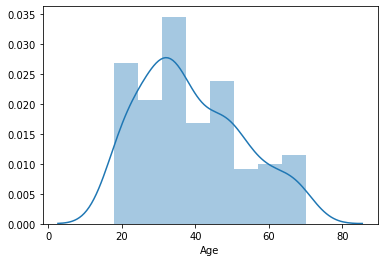

In [0]:
# 각 변수의 분포를 봅니다. 
sns.distplot(df['Age'])

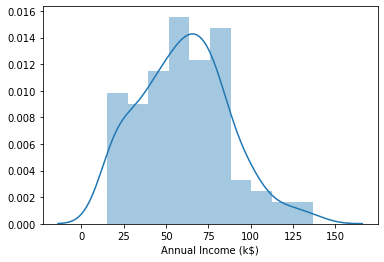

In [0]:
sns.distplot(df['Annual Income (k$)'])

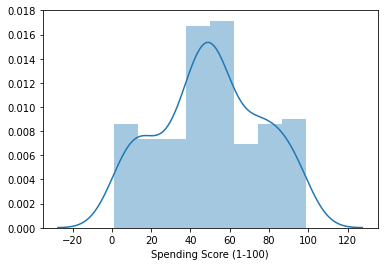

In [0]:
sns.distplot(df['Spending Score (1-100)'])

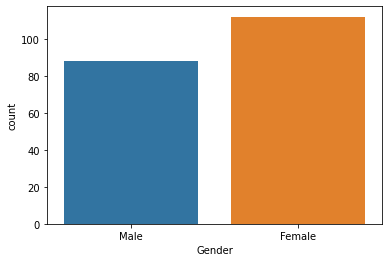

In [0]:
sns.countplot(data=df, x = "Gender")

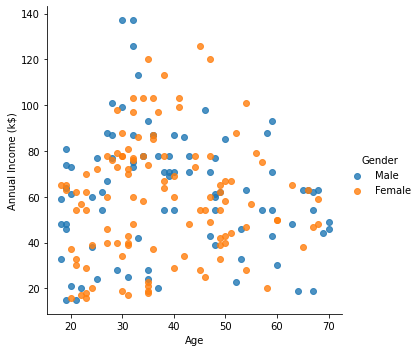

In [0]:
# 성별에 따른 분포도 확인해봅니다. 
sns.lmplot(data=df, x="Age", y = "Annual Income (k$)", hue = "Gender", fit_reg=False)

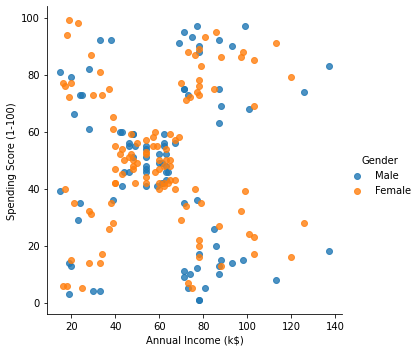

In [0]:
sns.lmplot(data=df, x="Annual Income (k$)", y = 'Spending Score (1-100)', hue = "Gender", fit_reg=False)

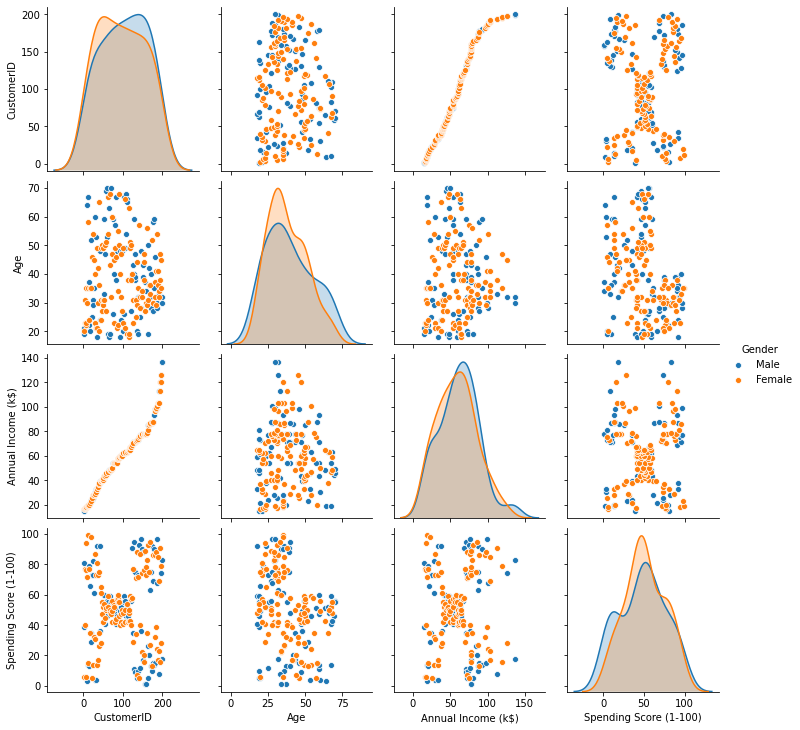

In [0]:
sns.pairplot(df[['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)']], hue = 'Gender')
plt.show()

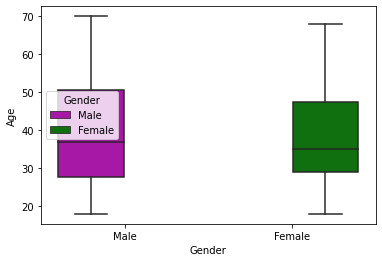

In [0]:
sns.boxplot(x="Gender", y='Age',
           hue="Gender", palette=["m", "g"],
           data=df)

## 데이터 분석

### K-means를 사용한 클러스터링
k-means는 가장 빠르고 단순한 클러스터링 방법 중 한 가지 입니다. 



scikit-learn의 cluster 서브패키지 KMeans 클래스를 사용합니다. 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

* **n_clusters**: 군집의 갯수 (default=8)
* **init**: 초기화 방법. `"random"`이면 무작위, `"k-means++"`이면 K-평균++ 방법.(default=k-means++)
* **n_init**: centroid seed 시도 횟수. 무작위 중심위치 목록 중 가장 좋은 값을 선택한다.(default=10)
* **max_iter**: 최대 반복 횟수.(default=300)
* **random_state**: 시드값.(default=None)

### Age & spending Score 두 가지 변수를 사용한 클러스터링 

In [0]:
from sklearn.cluster import KMeans

# X1에 'Age' , 'Spending Score (1-100)'의 값을 넣어줍니다.  
X1 = df[['Age' , 'Spending Score (1-100)']].values

# inertia 라는 빈 리스트를 만들어줍니다. 
inertia = []

# 군집수 n을 1에서 11까지 돌아가며 X1에 대해 k-means++ 알고리즘을 적용하여 inertia를 리스트에 저장합니다. 
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

In [0]:
# k-means 파라미터 설정이 복잡하다면 아래와 같이 실행해도 거의 동일한 결과가 나옵니다. 

'''
from sklearn.cluster import KMeans

# X1에 'Age' , 'Spending Score (1-100)'의 값을 넣어줍니다.  
X1 = df[['Age' , 'Spending Score (1-100)']].values

# inertia 라는 빈 리스트를 만들어줍니다. 
inertia = []

# 군집수 n을 1에서 11까지 돌아가며 X1에 대해 k-means++ 알고리즘을 적용하여 inertia를 리스트에 저장합니다. 
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n) )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
'''

In [0]:
inertia

[171535.5,
 75949.15601023017,
 45840.67661610867,
 28165.58356662934,
 23810.462233071365,
 19510.328802776174,
 15523.684014328752,
 13010.46287786288,
 11459.347653936242,
 10159.36972387989]

### Inertia value를 이용한 적정 k 선택 
* 관성(Inertia)에 기반하여 n 개수를 선택합니다. 
* 관성(Inertia) : 각 중심점(centroid)에서 군집 내 데이터간의 거리를 합산한 것으로 군집의 응집도를 나타냅니다. 이 값이 작을수록 응집도 높은 군집화 입니다. 즉, 작을 수록 좋은 값 입니다.  

https://scikit-learn.org/stable/modules/clustering.html
![Inertia](https://drive.google.com/file/d/1x9DAPSM8oM6hkYkR0ZVY1lt-CfknWaPw/view?usp=sharing)

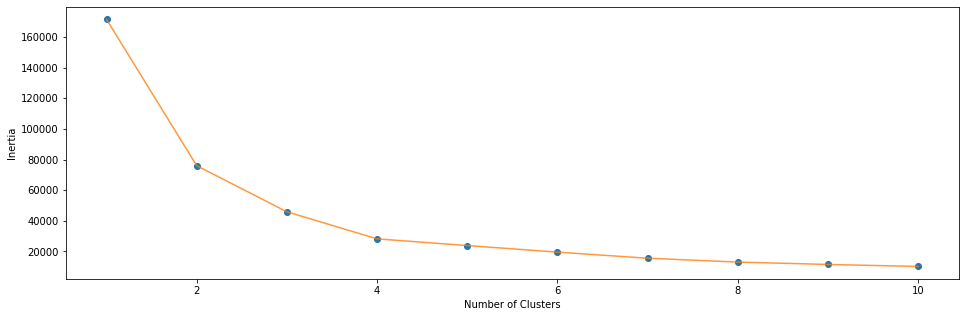

In [0]:
plt.figure(1 , figsize = (16 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.8)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

* k의 개수는 4개이면 적절해보입니다. 

In [0]:
# 군집수를 4로 지정하여 시각화 해봅니다. 
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

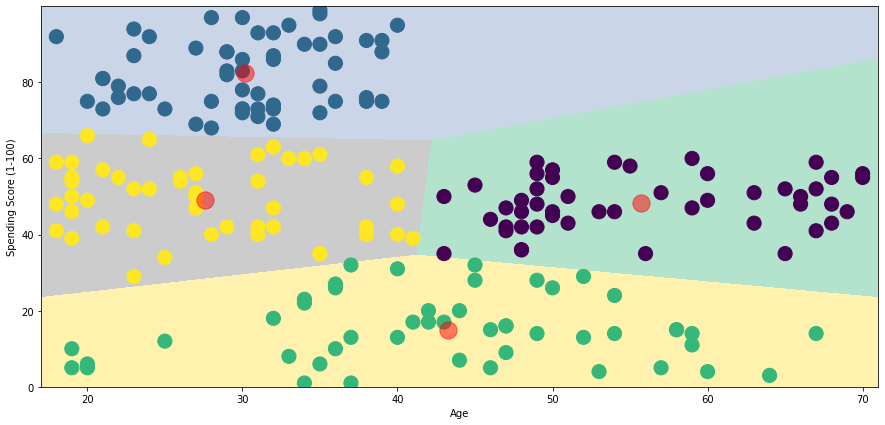

In [0]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

* 연령-소비점수를 활용한 군집 4개는 아래와 같이 명명할 수 있습니다. 
  * 저연령-고소비 군 
  * 저연령-중소비 군
  * 고연령-중소비 군
  * 저소비 군

* 군집별 활용 전략 예시
  * 이 수퍼마켓 mall의 경우 소비점수가 높은 고객들은 모두 40세 이하의 젊은 고객입니다.
  * 소비점수가 높은 고객들은 연령대가 비슷한 만큼 비슷한 구매패턴과 취향을 가질 가능성이 높습니다. 
  * 해당 군집의 소비자 특성을 더 분석해본 뒤 해당 군집의 소비자 대상 VIP 전략을 수립해봅니다.
  * 소비점수가 중간정도인 고객들에게는 연령에 따라 두 개 집단으로 나눠서 접근해봅니다. 
  * 소비점수가 낮은 고객군은 연령대별로 중소비점수 군집에 편입될 수 있도록 접근해봅니다.   

### 'Annual Income (k$)' , 'Spending Score (1-100)' 두 가지 변수를 사용한 클러스터링 

In [0]:
# X1에 'Annual Income (k$)' , 'Spending Score (1-100)' 의 값을 넣어줍니다.  
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)' ]].values

# inertia 라는 빈 리스트를 만들어줍니다. 
inertia = []

# 군집수 n을 1에서 11까지 돌아가며 X1에 대해 k-means++ 알고리즘을 적용하여 inertia를 리스트에 저장합니다. 
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n) )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

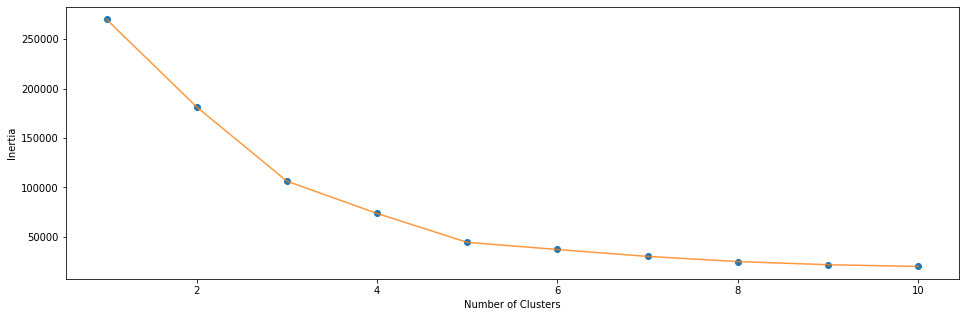

In [0]:
plt.figure(1 , figsize = (16 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.8)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [0]:
# 군집수를 5로 지정하여 시각화 해봅니다. 
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

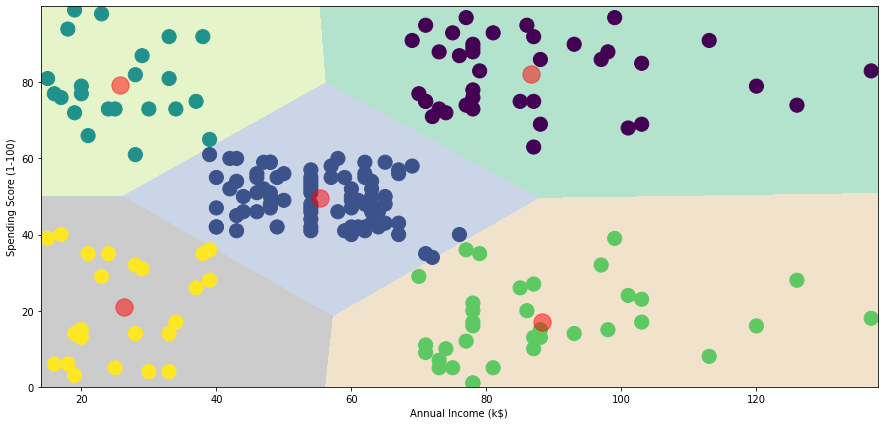

In [0]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

### 실루엣 스코어를 사용한 k 선택 

* 실루엣 스코어 
  * Silhouette Coefficient는 각 샘플의 클러스터 내부 거리의 평균 (a)와 인접 클러스터와의 거리 평균 (b)을 사용하여 계산합니다. 
  * 한 샘플의 Silhouette Coefficient는 (b - a) / max(a, b)입니다.
  * 가장 좋은 값은 1이고 최악의 값은 -1입니다. 
  * 0 근처의 값은 클러스터가 오버랩되었다는 것을 의미합니다
  * 음수 값은 샘플이 잘못된 클러스터에 배정되었다는 것을 의미합니다. 다른 클러스터가 더 유사한 군집이라는 의미입니다. 
  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette_score#sklearn.metrics.silhouette_score


In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.293166070535953
For n_clusters = 3 The average silhouette_score is : 0.3839349967742105
For n_clusters = 4 The average silhouette_score is : 0.40546302077733304
For n_clusters = 5 The average silhouette_score is : 0.44428597560893024
For n_clusters = 6 The average silhouette_score is : 0.4523443947724053
For n_clusters = 7 The average silhouette_score is : 0.43978902692261157
For n_clusters = 8 The average silhouette_score is : 0.43360130415308396


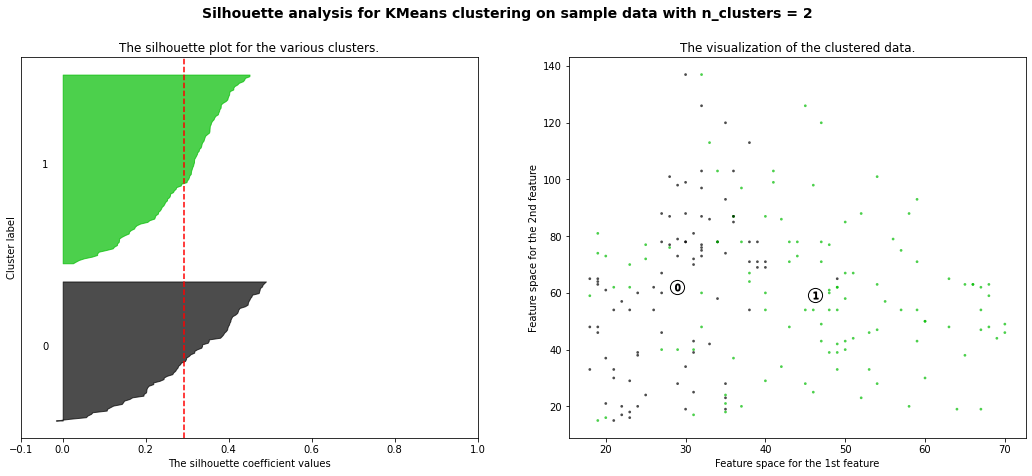

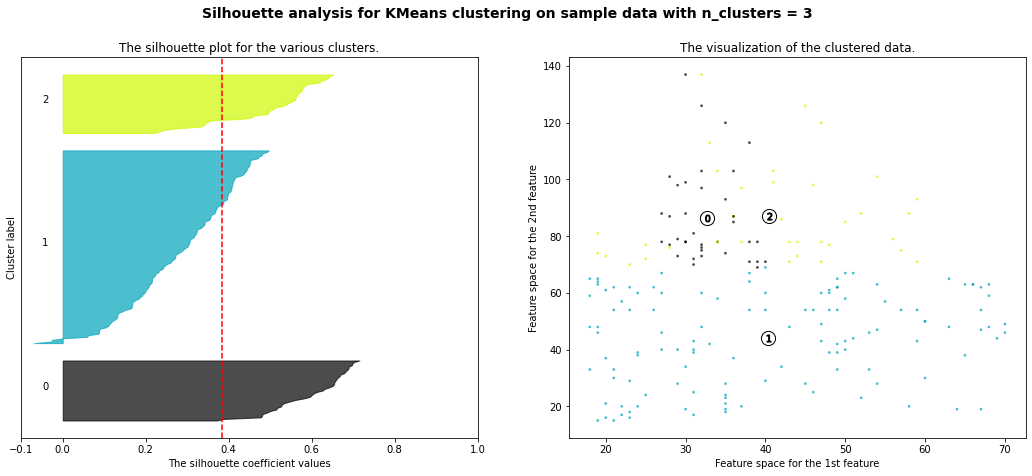

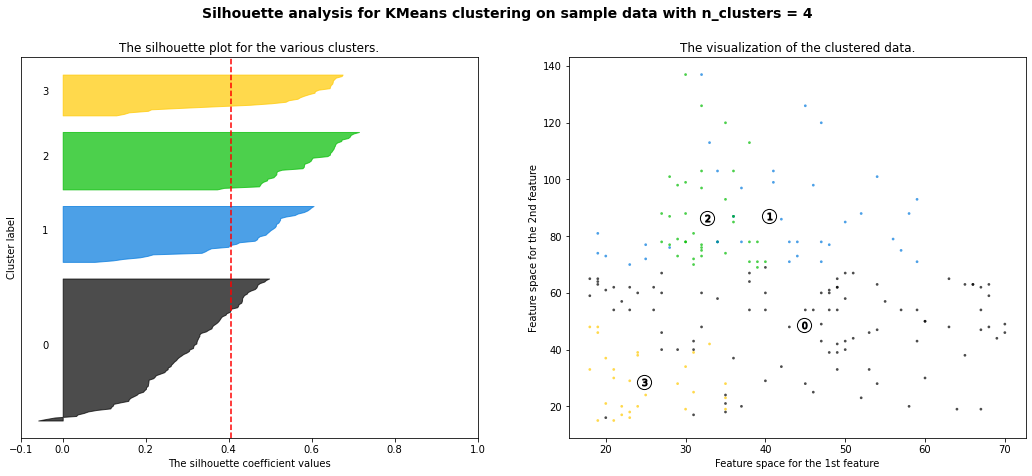

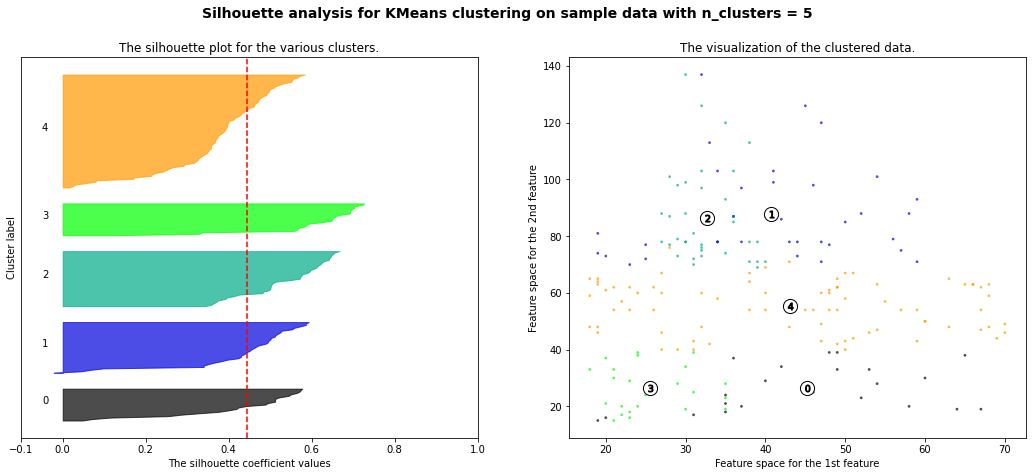

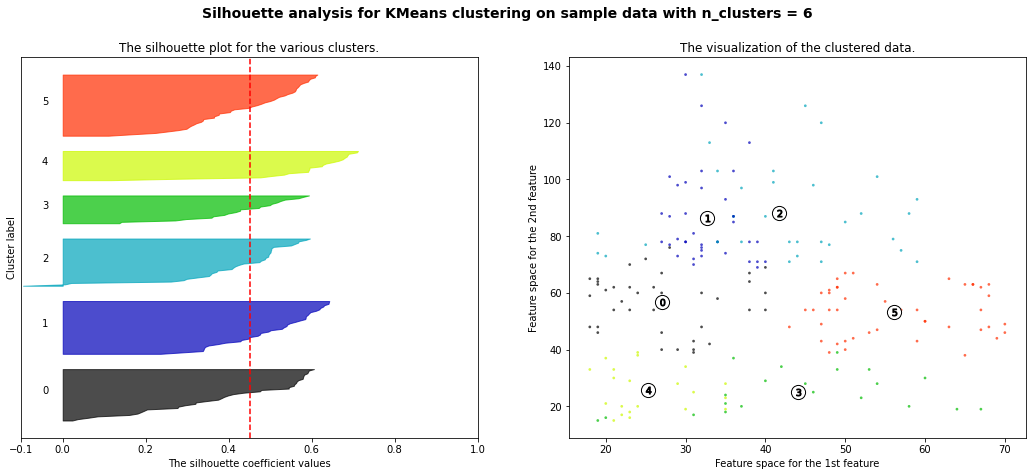

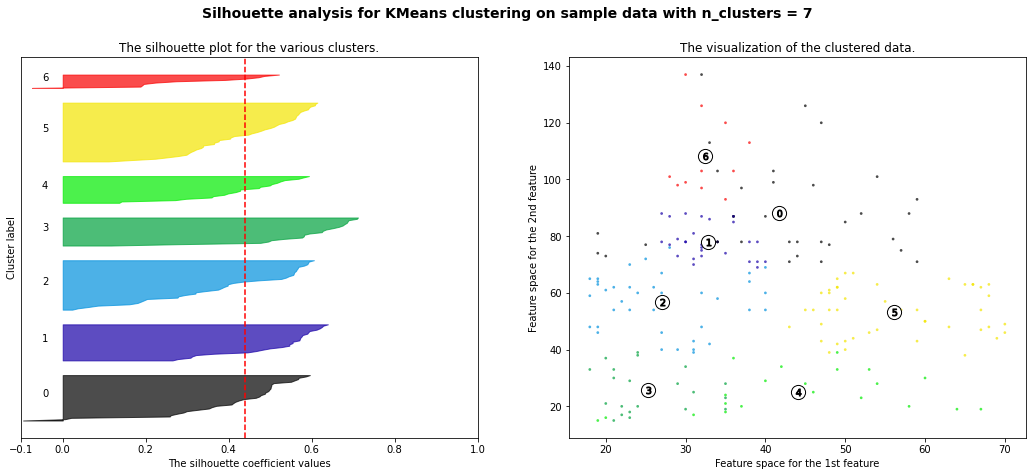

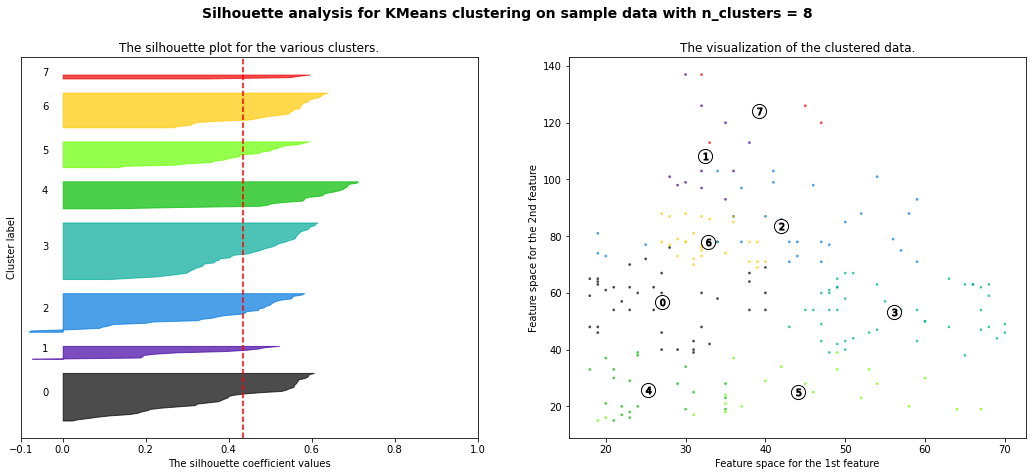

In [0]:
# 클러스터의 갯수 리스트를 만들어줍니다. 
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# 사용할 컬럼 값을 지정해줍니다. 
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values


for n_clusters in range_n_clusters:
    # 1 X 2 의 서브플롯을 만듭니다. 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 첫 번째 서브플롯은 실루엣 플롯입니다. 
    # silhouette coefficient는 -1에서 1 사이의 값을 가집니다.
    # 하지만 시각화에서는 -0.1에서 1사이로 지정해줍니다. 
    ax1.set_xlim([-0.1, 1])

    # clusterer를 n_clusters 값으로 초기화 해줍니다.  
    # 재현성을 위해 random seed를 10으로 지정 합니다.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # silhouette_score는 모든 샘플에 대한 평균값을 제공합니다. 
    # 실루엣 스코어는 형성된 군집에 대해 밀도(density)와 분리(seperation)에 대해 견해를 제공합니다. 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 각 샘플에 대한 실루엣 스코어를 계산합니다. 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속한 샘플들의 실루엣 스코어를 취합하여 정렬합니다. 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 각 클러스터의 이름을 달아서 실루엣 플롯의 Label을 지정해줍니다. 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 플롯을 위한 새로운 y_lower를 계산합니다.
        y_lower = y_upper + 10  # 10 for the 0 samples






    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # 모든 값에 대한 실루엣 스코어의 평균을 수직선으로 그려줍니다. 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # yaxis labels / ticks 를 지워줍니다. 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 두 번째 플롯이 실제 클러스터가 어떻게 형성되었는지 시각화 합니다. 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # 클러스터의 이름을 지어줍니다. 
    centers = clusterer.cluster_centers_
    # 클러스터의 중앙에 하얀 동그라미를 그려줍니다. 
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

* 클러스터의 개수는 6개가 가장 적절합니다. 

For n_clusters = 6 The average silhouette_score is : 0.4523443947724053


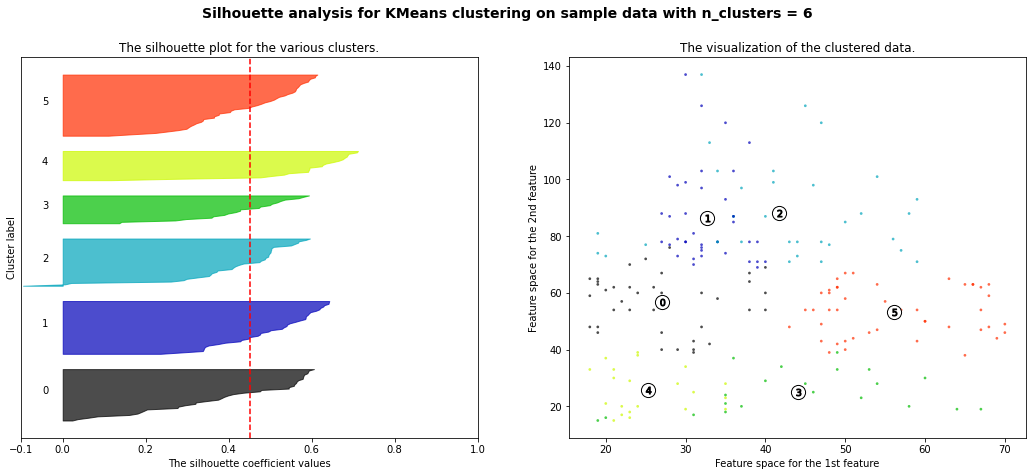

In [0]:
# 클러스터의 갯수 리스트를 만들어줍니다. 
range_n_clusters = [6]

# 사용할 컬럼 값을 지정해줍니다. 
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values


for n_clusters in range_n_clusters:
    # 1 X 2 의 서브플롯을 만듭니다. 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 첫 번째 서브플롯은 실루엣 플롯입니다. 
    # silhouette coefficient는 -1에서 1 사이의 값을 가집니다.
    # 하지만 시각화에서는 -0.1에서 1사이로 지정해줍니다. 
    ax1.set_xlim([-0.1, 1])

    # clusterer를 n_clusters 값으로 초기화 해줍니다.  
    # 재현성을 위해 random seed를 10으로 지정 합니다.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # silhouette_score는 모든 샘플에 대한 평균값을 제공합니다. 
    # 실루엣 스코어는 형성된 군집에 대해 밀도(density)와 분리(seperation)에 대해 견해를 제공합니다. 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 각 샘플에 대한 실루엣 스코어를 계산합니다. 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속한 샘플들의 실루엣 스코어를 취합하여 정렬합니다. 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 각 클러스터의 이름을 달아서 실루엣 플롯의 Label을 지정해줍니다. 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 플롯을 위한 새로운 y_lower를 계산합니다.
        y_lower = y_upper + 10  # 10 for the 0 samples






    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # 모든 값에 대한 실루엣 스코어의 평균을 수직선으로 그려줍니다. 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # yaxis labels / ticks 를 지워줍니다. 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 두 번째 플롯이 실제 클러스터가 어떻게 형성되었는지 시각화 합니다. 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # 클러스터의 이름을 지어줍니다. 
    centers = clusterer.cluster_centers_
    # 클러스터의 중앙에 하얀 동그라미를 그려줍니다. 
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [0]:
print(cluster_labels.shape)
print(X.shape)

(200,)
(200, 3)


In [0]:
cluster_labels

array([3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 5, 4, 5, 0,
       3, 4, 5, 0, 0, 0, 5, 0, 0, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 0,
       5, 5, 0, 0, 5, 5, 5, 5, 5, 0, 5, 0, 0, 5, 5, 0, 5, 5, 0, 5, 5, 0,
       0, 5, 5, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 5, 5, 0, 5, 0, 5, 5, 5, 5,
       5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1,
       0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1], dtype=int32)

In [0]:
# 기존 데이터셋에 각 고객이 속한 클러스터 값을 넣어줍니다. 
df["cluster"] = cluster_labels
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,4
2,3,Female,20,16,6,3
3,4,Female,23,16,77,4
4,5,Female,31,17,40,3
...,...,...,...,...,...,...
195,196,Female,35,120,79,1
196,197,Female,45,126,28,2
197,198,Male,32,126,74,1
198,199,Male,32,137,18,2


In [0]:
# 각 그룹의 특성을 확인합니다. 
df.groupby("cluster")["Age"].mean()

cluster
0    27.000000
1    32.692308
2    41.685714
3    44.142857
4    25.272727
5    56.155556
Name: Age, dtype: float64

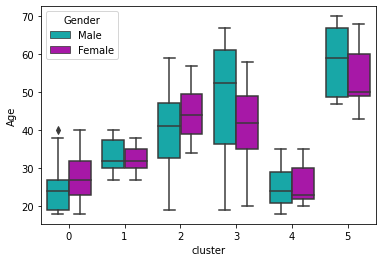

In [0]:
sns.boxplot(x='cluster', y="Age", hue="Gender", palette=["c", "m"], data=df)

* boxplot은 중앙값, 표준 편차 등, 분포의 간략한 특성을 보여줍니다. 
* 각 카테고리 값에 따른 분포의 실제 데이터와 형상을 보고 싶다면  violinplot, stripplot, swarmplot 등으로 시각화 해봅니다.

* violinplot은 세로 방향으로 커널 밀도 히스토그램을 그려줍니다. 양쪽이 왼쪽, 오른쪽 대칭이 되도록 하여 바이올린처럼 보입니다.

* violinplot: http://seaborn.pydata.org/generated/seaborn.violinplot.html

* swarmplot은 stripplot과 유사하며 데이터를 나타내는 점이 겹치지 않도록 옆으로 이동해서 그려줍니다.

* swarmplot: http://seaborn.pydata.org/generated/seaborn.swarmplot.html

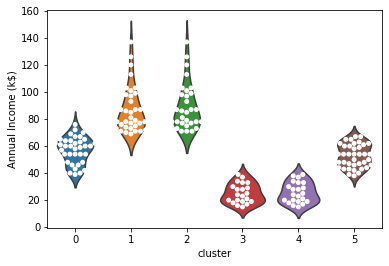

In [0]:
ax = sns.violinplot(x="cluster", y='Annual Income (k$)', data=df, inner=None)
ax = sns.swarmplot(x="cluster", y='Annual Income (k$)', data=df,
                   color="white", edgecolor="gray")

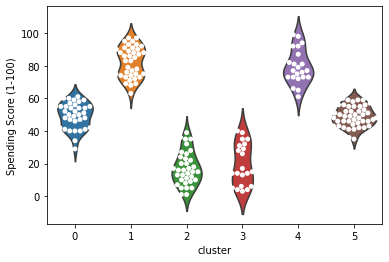

In [0]:
ax = sns.violinplot(x="cluster", y='Spending Score (1-100)', data=df, inner=None)
ax = sns.swarmplot(x="cluster", y='Spending Score (1-100)', data=df,
                   color="white", edgecolor="gray")

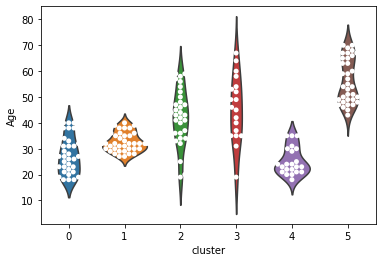

In [0]:
ax = sns.violinplot(x="cluster", y='Age', data=df, inner=None)
ax = sns.swarmplot(x="cluster", y='Age', data=df,
                   color="white", edgecolor="gray")

In [0]:
# 3차원으로 시각화 해봅니다. 
import plotly.graph_objs as go
import plotly as py

df['label3'] =  cluster_labels
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label3'], 
        size= 20,
        line=dict(
            color= df['label3'],
            width= 20
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

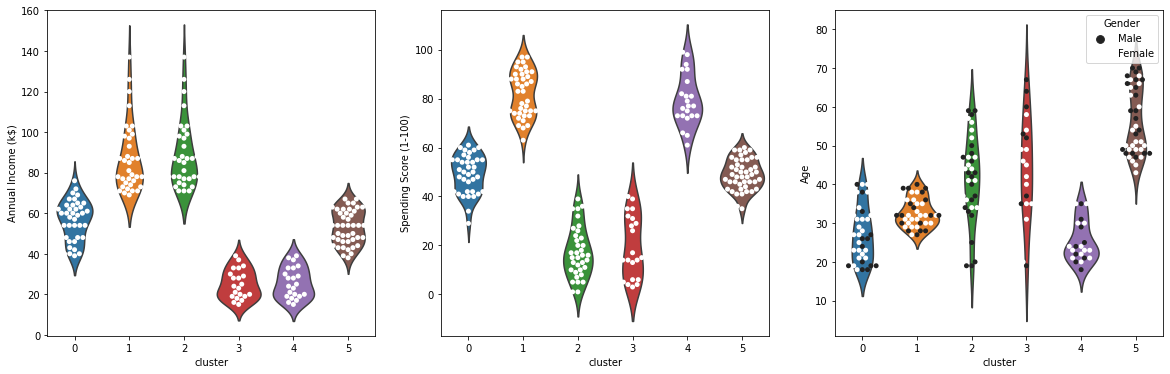

In [0]:
# 3개의 시각화를 한 화면에 배치합니다. 
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)

# 시각화의 사이즈를 설정해줍니다. 
figure.set_size_inches(20, 6)

# 클러스터별로 swarmplot을 시각화해봅니다. 
ax1 = sns.violinplot(x="cluster", y='Annual Income (k$)', data=df, inner=None, ax=ax1)
ax1 = sns.swarmplot(x="cluster", y='Annual Income (k$)', data=df,
                   color="white", edgecolor="gray", ax=ax1)

ax2 = sns.violinplot(x="cluster", y='Spending Score (1-100)', data=df, inner=None, ax=ax2)
ax2 = sns.swarmplot(x="cluster", y='Spending Score (1-100)', data=df,
                   color="white", edgecolor="gray", ax=ax2)

ax3 = sns.violinplot(x="cluster", y='Age', data=df, inner=None, ax=ax3)
ax3 = sns.swarmplot(x="cluster", y='Age', data=df,
                   color="white", edgecolor="gray", ax=ax3, hue="Gender")


### 적용 방안 
  * 각 클러스터 별 특성을 정리해서 각 클러스터별 접근방안을 고민해봅니다. 

||0|1|2|3|4|5|
|------|---|---|---|---|---|---|
|연간 소득|中|上|上|下|下|中|
|소비 점수|中|上|下|下|上|中|
|연령|下|中|ㅇ|ㅇ|下|上|


* VIP 고객 : 군집 1, 군집 4 
  - 소비 점수가 높은 군집은 1, 4입니다. 
  - 군집1 
    * 그 중에서도 1의 연간소득은 높은편입니다. 
    * 잘 유도할 경우 더 많은 지출을 하게 될지도 모르겠습니다. 
    * 1의 연령대는 20대후반에서 40대 초반으로 젊은편입니다. 
    * 1의 세부 고객 정보를 더 분석해서 타겟 마케팅을 기획해 봅니다. 
    * 고소득 젊은층이 선호할 이벤트를 기획하거나 사은품을 기획해 볼 수 있을것입니다. 
  - 군집4 
    * 연간 소득은 낮은편이지만 우리 mall에서의 소비점수는 높은편입니다.
    * 특히 우리 mall에 대한 충성도가 높고 구매비율이 높은 고객군으로 추정됩니다. 
    * 가격적인 혜택을 추가 제공하는 것을 고려해봅니다. (할인쿠폰, 멤버십 등)  

* 잠재 VIP 고객 : 군집 2
  - 연간소득은 높지만 소비 점수는 낮은 편입니다. 
  - 우리 mall에서 구매를 더 할 수 있는 여력이 있는 고객군입니다. 
  - 연령은 전 연령대에 걸쳐 있습니다. 
  - 다른 변수를 더 확보하여 잠재 VIP 고객이 될 수 있는 cluster 2 고객의 방문과 구매를 유도해봅니다. 
  - 재방문시 사은품 증정, 특정 금액 이상 구매시 혜택 제공 등 재방문과 구매를 유도해봅니다. 


<style>
td {
  font-size: 50px
}
|&#60;font size=4&#62;Project&#60;/font&#62;|&#60;font size=4&#62;Project Type&#60;/font&#62;|&#60;font size=4&#62;Status&#60;/font&#62;|<br>
|---|---|---|<br>
|&#60;font size=4&#62;Hello phase 1&#60;/font&#62;|&#60;font size=4&#62;ABC&#60;/font&#62;|&#60;font size=4&#62;Ongoing&#60;/font&#62;|<br>
|&#60;font size=4&#62;Goodbye analytics&#60;/font&#62;|&#60;font size=4&#62;EFG&#60;/font&#62;|&#60;font size=4&#62;Completed&#60;/font&#62;|
</style>

### 추가 분석을 해본다면 
* "Gender" 변수 활용 
  - K-means는 기본적으로 numerical variable을 사용하는 알고리즘입니다. 유클리디안 거리를 계산해야하기 때문입니다. 
  - Gender 변수를 one-hot-encoding하여 숫자로 바꿔준 뒤 변수로 추가하여 활용해봅니다. 
  
### 카테고리 변수가 대부분인 경우의 군집화  
* k-modes 알고리즘을 사용합니다. 
* https://pypi.org/project/kmodes/

### Next Step
* 각 세그먼트별 활용전략 도출
* 전략에 따른 가설과 실험 설계
* AB Test 
* Loop